In [1]:
# Setup necessary libraries

% pylab inline
# see https://ipython.readthedocs.io/en/stable/interactive/magics.html

% config InlineBackend.figure_format = 'svg'
from bs4 import BeautifulSoup
import json
import os
import pandas as pd
import urllib
import gmaps

import matplotlib.pyplot as plt
% matplotlib inline
plt.xticks(rotation=90)


print("Pandas version:", pd.__version__)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 125)
pd.set_option('display.precision', 3)

Populating the interactive namespace from numpy and matplotlib
Pandas version: 0.23.4


In [2]:
## Get Turnstile Data
# Get a list of links to all turnstile data from 2015 on
def get_links():
    data = urllib.request.urlopen('http://web.mta.info/developers/turnstile.html')
    soup = BeautifulSoup(data, 'lxml')
    links = soup.findAll("div", {"class": "span-84 last"})
    links_list = links[0].find_all("a")
    
    files = []
    for link in links_list:
        files.append(str(link).split('"')[1])
    
    after_2014 = []
    for file in files:
        if (int(file.split('_')[1].split('.')[0])) > 150000:
            after_2014.append('http://web.mta.info/developers/'+file)
            
    return after_2014
  
    
# Grab all datasets from the month of september from 2015-2018  
def get_sep_data():
    data = get_links()
    sep_list = []
    for link in data:
        if link.split('_')[1].split('.')[0][2:4] == '09':
            print(link)
            sep_list.append(pd.read_csv(link, header=0, dtype={'ENTRIES': int, 'EXITS': int}))
    return pd.concat(sep_list)

In [3]:
# Load Turnstile data
sep_data = get_sep_data()

http://web.mta.info/developers/data/nyct/turnstile/turnstile_180929.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_180922.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_180915.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_180908.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_180901.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_170930.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_170923.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_170916.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_170909.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_170902.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_160924.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_160917.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_160910.txt
http://web.mta.info/developers/data/nyct/turnstile/turnstile_160

In [5]:
# # Get turnstile data
# df2 = pd.read_csv(
#     'http://web.mta.info/developers/data/nyct/turnstile/turnstile_180922.txt'
#     )
# # Set variables for the API
# gmaps_base_url = 'https://maps.googleapis.com/maps/api/geocode/json?'
# api_key = os.environ["GOOGLE_API_KEY"]
# scontext = None

# # Create a list of station to source the search on Google API
# mta_stations = list(df2['STATION'].unique())


# def get_stations():
#     # Create a dataframe to collect search results
#     locs = pd.DataFrame(data=None)

#     for station in mta_stations:
#         try:
#             search_criteria = {'address': station + 'Subway station, New York, NY',
#                                'key' : api_key
#                                }
#             url = gmaps_base_url + urllib.parse.urlencode(search_criteria)
#             uh = urllib.request.urlopen(url, context=scontext)
#             data = uh.read()
#             js = json.loads(data)
#             lat = js['results'][0]['geometry']['location']['lat']
#             long = js['results'][0]['geometry']['location']['lng']
#             locs = locs.append(pd.Series((station, lat, long)), ignore_index=True)
#         except:
#             print(station)
            
#     locs.rename(columns={0: 'STATION',1: 'LATITUDE',2: 'LONGITUDE'}, inplace=True)
    
#     return locs

In [4]:
# # Load Station Data
# stations = get_stations()

# Load by .csv
stations = pd.read_csv('mtaLongLat.csv', sep='\t', encoding='utf-8', header=0, dtype={'LATITUDE': float, 'LONGITUDE': float})

In [5]:
# Helper function for data transform
def fix_counter(x,y):
    if y > pd.Timedelta(hours=24):
        return 0
    elif x < -150000:
        return 0
    elif x < 1:
        return -x
    elif x > 150000:
        return 0
    else:
        return x

In [6]:
## Transform Data to have datetime-stamps and adjusted entry counters for every four hour window
def data_transform(df):
    
    # First, create new date/time column, along with separate day and hour columns and day of the week
    df['DATETIME'] = df['DATE'] + ' ' + df['TIME']
    df['DATETIME'] = pd.to_datetime(df['DATETIME'],format='%m/%d/%Y %H:%M:%S')
    df['DAY'] = df['DATETIME'].dt.day
    df['HOUR'] = df['DATETIME'].dt.hour
    df['WEEKDAY'] = df.apply(lambda row: row['DATETIME'].isoweekday(), axis=1)

    # Drop original Date and Time columns
    dropcolumns = ['DATE','TIME']
    df.drop(dropcolumns,inplace=True,axis=1)
    
    # Rename Exits
    df = df.rename(columns = {'EXITS                                                               ':'EXITS'})
    
    # Get rid of the duplicate entries (where DESC == 'RECOVR AUD')
    df = df[df.DESC!='RECOVR AUD']
    
    # Create Prev_date and Prev_Entry columns, while shifting entries to previous entries
    df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATETIME"], inplace=True, ascending=False)
    df[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (df.groupby(["C/A", "UNIT", "SCP", "STATION"])['DATETIME', "ENTRIES", "EXITS"].transform(lambda grp: grp.shift(1)))
    
    # Drop records where PREV_DATE is null
    df.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
    
    # Define datatypes for PREV_ENTRIES and PREV_EXITS
    df['PREV_ENTRIES']= df['PREV_ENTRIES'].astype(int)
    df['PREV_EXITS']= df['PREV_EXITS'].astype(int)
    
    # Time Difference = Date-Time Stamp of the Record - Previous Audit
    df['TIME_DIFF'] = df['DATETIME'] - df['PREV_DATE'] 
    
    # Entries Count = Count on the Record (agg) - Previous Count (agg)
    df['ENTRIES_DIFF'] = df['ENTRIES'] - df['PREV_ENTRIES']
    
    # Entries Count = Count on the Record (agg) - Previous Count (agg)
    df['EXITS_DIFF'] = df['EXITS'] - df['PREV_EXITS']
    
    # Adjust counter by reversing/replacing negative or large numbers
    df['ENTRY_COUNT'] = df.apply(lambda row: fix_counter(row['ENTRIES_DIFF'],row['TIME_DIFF']), axis=1)
    df['EXIT_COUNT'] = df.apply(lambda row: fix_counter(row['EXITS_DIFF'],row['TIME_DIFF']), axis=1)

    
    return df 

In [7]:
# Transform the turnstile (September 2015~2018) data
transformed_df = data_transform(sep_data)

In [8]:
# Merge Turnstile data with Lat/Lon info for stations
merged_df = transformed_df.merge(stations, how='left')

In [9]:
# Subset a dataframe based on boundaries of latitude and longitude

def within_bounds(df,lat1,lat2,lon1,lon2):
    return df[((df['LATITUDE']>lat1)&(df['LATITUDE']<lat2))&
              ((df['LONGITUDE']>lon1) & (df['LONGITUDE']<lon2))]

In [11]:
# Set boundaries for the heat map
mid_manhattan = within_bounds(merged_df,40.74,40.76,-73.998,-73.97)
bot_manhattan = within_bounds(merged_df,40.701,40.7135,-74.01,-73.99)
right_centralp = within_bounds(merged_df, 40.778, 40.79, -73.95, -73.945)

# Template for splitting dfs into part of the day
morning_df = merged_df[merged_df['HOUR'].isin([7,8,9,10,11,12])]
afternoon_df = merged_df[merged_df['HOUR'].isin([13,14,15,16,18,19])]
evening_df = merged_df[merged_df['HOUR'].isin([20,21,22,23,24,0])]
nighttime_df = merged_df[merged_df['HOUR'].isin([1,2,3,4,5,6])]

mid_morning_weekday = mid_manhattan[(mid_manhattan['HOUR'].isin([7,8,9,10,11,12]))
                                    &(mid_manhattan['WEEKDAY']<6)]
bot_morning_weekday = bot_manhattan[(bot_manhattan['HOUR'].isin([7,8,9,10,11,12]))
                                    &(bot_manhattan['WEEKDAY']<6)]
right_morning_weekday = right_centralp[(right_centralp['HOUR'].isin([7,8,9,10,11,12]))
                                    &(right_centralp['WEEKDAY']<6)]

mid_evening_weekday = mid_manhattan[(mid_manhattan['HOUR'].isin([20,21,22,23,24,0]))
                                    &(mid_manhattan['WEEKDAY']<6)]
bot_evening_weekday = bot_manhattan[(bot_manhattan['HOUR'].isin([20,21,22,23,24,0]))
                                    &(bot_manhattan['WEEKDAY']<6)]
right_evening_weekday = right_centralp[(right_centralp['HOUR'].isin([20,21,22,23,24,0]))
                                    &(right_centralp['WEEKDAY']<6)]

In [ ]:
# Create render_map function
def render_map(df, column, max_int, radius):
    gmaps.configure(api_key=os.environ["GOOGLE_API_KEY"])

    fig = gmaps.figure()
    heatmap_layer = gmaps.heatmap_layer(
        df[['LATITUDE', 'LONGITUDE']], weights=df[column],
        max_intensity=max_int, point_radius=radius
    )
    fig.add_layer(heatmap_layer)
    return fig


In [ ]:
# Render maps
render_map(mid_morning_weekday, 'EXIT_COUNT', 2000000, 20)
render_map(mid_evening_weekday, 'ENTRY_COUNT', 1000000, 20)
render_map(bot_morning_weekday, 'EXIT_COUNT', 2000000, 20)
render_map(bot_evening_weekday, 'ENTRY_COUNT', 2000000, 20)

In [119]:
# Stations in Queens
Queens = ['VERNON-JACKSON', 'HUNTERS PT AV', 'JACKSON AV', '21 ST']
Area_Queens = 'QUEENS'
Queens_df = pd.DataFrame({'STATION': Queens, 'AREA': Area_Queens})
# Stations in Brooklyn 
Brooklyn = ['GRAHAM AV', 'GREENPOINT AV', 'BEDFORD AV', 'LORIMER ST','HEWES ST', 'METROPOLITAN AV', 'MONTROSE AV']
Area_Brooklyn = 'BROOKLYN'
Brooklyn_df = pd.DataFrame({'STATION': Brooklyn, 'AREA': Area_Brooklyn})
# Midtown Manhattan
Midtown = ['49 ST', '42 ST-PORT AUTH', 'TIMES SQ-42 ST', '34 ST-PENN STA', '47-50 STS ROCK', 'GRD CNTRL-42 ST', '28 ST', '23 ST', '6 AV', '33 ST', '34 ST-HERALD SQ', 'TWENTY THIRD ST', '42 ST-BRYANT PK', '51 ST', 'NEWARK C']
Area_Midtown = 'MIDTOWN'
Midtown_df = pd.DataFrame({'STATION': Midtown, 'AREA': Area_Midtown})
# Downtown Manhattan
Downtown = ['WALL ST', 'FULTON ST', '176 ST', 'NEWARK HW BMEBE', 'NEWARK BM BW', 'PATH NEW WTC', 'BROOKLYN BRIDGE', 'NASSAU AV', 'NEWARK HM HE', 'WORLD TRADE CTR', 'CATHEDRAL PKWY', 'PATH WTC 2', 'CRESCENT ST', 'CITY HALL', 'YORK ST']
Area_Downtown = 'DOWNTOWN'
Downtown_df = pd.DataFrame({'STATION': Downtown, 'AREA': Area_Downtown})
# Right of Central Park
CentralPark = ['96 ST', '96 ST-2 AVE']
Area_CentralPark = 'CENTRAL PARK'
CentralPark_df = pd.DataFrame({'STATION': CentralPark, 'AREA': Area_CentralPark})

# Create Dataframe: Areas with the highest activity of Women in Tech
Tech_Wmn = Queens_df.append([Brooklyn_df, Midtown_df, Downtown_df, CentralPark_df])
Tech_Wmn

,STATION,AREA
0,VERNON-JACKSON,QUEENS
1,HUNTERS PT AV,QUEENS
2,JACKSON AV,QUEENS
3,21 ST,QUEENS
0,GRAHAM AV,BROOKLYN
1,GREENPOINT AV,BROOKLYN
2,BEDFORD AV,BROOKLYN
3,LORIMER ST,BROOKLYN
4,HEWES ST,BROOKLYN
5,METROPOLITAN AV,BROOKLYN


In [120]:
# Below table shows the top 5 stations for each weekday with the highest number of turnstile counts
# Total turnstile counts = average number (per day - "morning" range) of entries and exits combined
morning_df_flt = morning_df.merge(Tech_Wmn)
morning_df_days_maxent = morning_df_flt.groupby(['WEEKDAY', 'STATION', 'LATITUDE', 'LONGITUDE'],as_index=False)['ENTRY_COUNT', 'EXIT_COUNT'].mean()
morning_df_days_maxent['TOTAL_COUNT'] = morning_df_days_maxent['ENTRY_COUNT'] + morning_df_days_maxent['EXIT_COUNT']
morning_df_days_maxent = morning_df_days_maxent.sort_values(['WEEKDAY', 'TOTAL_COUNT'], ascending=[1,0]).groupby('WEEKDAY').head(5)
morning_df_days_maxent

,WEEKDAY,STATION,LATITUDE,LONGITUDE,ENTRY_COUNT,EXIT_COUNT,TOTAL_COUNT
22,1,GRD CNTRL-42 ST,40.758,-73.992,479.656,540.000,1019.656
42,1,YORK ST,40.701,-73.987,395.632,499.333,894.965
7,1,42 ST-BRYANT PK,40.755,-73.984,208.612,595.961,804.573
5,1,34 ST-HERALD SQ,40.749,-73.989,353.412,445.855,799.267
15,1,BEDFORD AV,40.718,-73.958,447.193,305.956,753.149
85,2,YORK ST,40.701,-73.987,506.611,654.407,1161.019
79,2,PATH WTC 2,40.713,-74.010,79.756,904.953,984.709
50,2,42 ST-BRYANT PK,40.755,-73.984,256.713,659.090,915.803
48,2,34 ST-HERALD SQ,40.749,-73.989,384.904,501.127,886.031
65,2,GRD CNTRL-42 ST,40.758,-73.992,366.791,495.794,862.586


In [121]:
# Below table shows the top 5 stations for each weekday with the highest number of turnstile counts
# Total turnstile counts = average number (per day - "evening" range) of entries and exits combined
evening_df_flt = evening_df.merge(Tech_Wmn)
evening_df_days_maxent = evening_df_flt.groupby(['WEEKDAY', 'STATION', 'LATITUDE', 'LONGITUDE'],as_index=False)['ENTRY_COUNT', 'EXIT_COUNT'].mean()
evening_df_days_maxent['TOTAL_COUNT'] = evening_df_days_maxent['ENTRY_COUNT'] + evening_df_days_maxent['EXIT_COUNT']
evening_df_days_maxent = evening_df_days_maxent.sort_values(['WEEKDAY', 'TOTAL_COUNT'], ascending=[1,0]).groupby('WEEKDAY').head(5)
evening_df_days_maxent

,WEEKDAY,STATION,LATITUDE,LONGITUDE,ENTRY_COUNT,EXIT_COUNT,TOTAL_COUNT
15,1,BEDFORD AV,40.718,-73.958,153.573,185.242,338.815
29,1,MONTROSE AV,40.708,-73.940,105.988,165.345,271.333
42,1,YORK ST,40.701,-73.987,179.463,90.019,269.481
37,1,TIMES SQ-42 ST,40.755,-73.987,185.272,80.953,266.225
19,1,CRESCENT ST,40.683,-73.873,52.444,211.185,263.630
82,2,VERNON-JACKSON,40.743,-73.954,48.121,441.796,489.917
58,2,BEDFORD AV,40.718,-73.958,198.115,268.067,466.182
85,2,YORK ST,40.701,-73.987,196.685,107.130,303.815
80,2,TIMES SQ-42 ST,40.755,-73.987,221.735,81.198,302.933
72,2,MONTROSE AV,40.708,-73.940,110.964,175.226,286.190


In [124]:
mdf_ent_grpd = morning_df[(morning_df.DATETIME <= '2018-01-01') & (morning_df.DATETIME <= '2018-01-01')].groupby(['STATION', 'LATITUDE', 'LONGITUDE'],as_index=False)['EXIT_COUNT'].sum()
mdf_ent_grpd.sort_values(["EXIT_COUNT"], inplace=True, ascending=False)
adf_ent_grpd = afternoon_df[(afternoon_df.DATETIME <= '2018-01-01') & (afternoon_df.DATETIME <= '2018-01-01')].groupby(['STATION', 'LATITUDE', 'LONGITUDE'],as_index=False)['ENTRY_COUNT'].sum()
adf_ent_grpd.sort_values(["ENTRY_COUNT"], inplace=True, ascending=False)
edf_ent_grpd = evening_df[(evening_df.DATETIME <= '2018-01-01') & (evening_df.DATETIME <= '2018-01-01')].groupby(['STATION', 'LATITUDE', 'LONGITUDE'],as_index=False)['ENTRY_COUNT'].sum()
edf_ent_grpd.sort_values(["ENTRY_COUNT"], inplace=True, ascending=False)

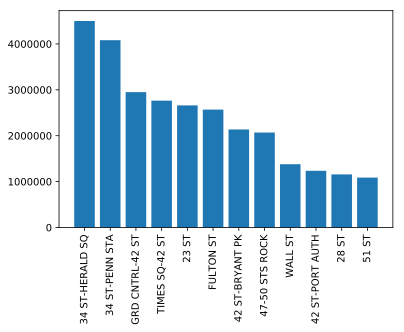

In [135]:
plt.xticks(rotation=90)
graph_morning = mdf_ent_grpd[mdf_ent_grpd.EXIT_COUNT>1000000].merge(Tech_Wmn)
bar_gm = plt.bar(graph_morning.STATION, graph_morning.EXIT_COUNT)

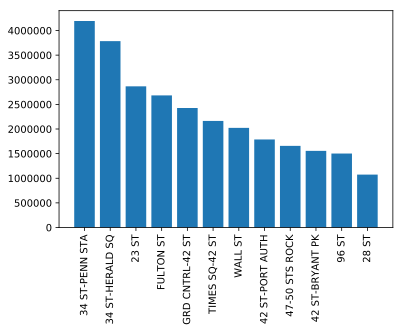

In [133]:
plt.xticks(rotation=90)
graph_afternoon = adf_ent_grpd[adf_ent_grpd.ENTRY_COUNT>1000000].merge(Tech_Wmn)
bar_gm = plt.bar(graph_afternoon.STATION, graph_afternoon.ENTRY_COUNT)

/home/aglee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


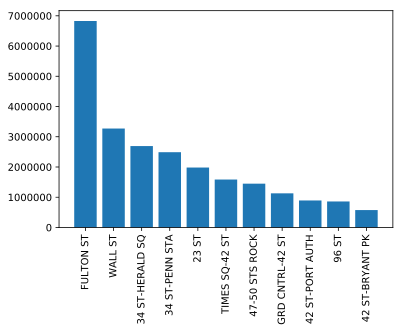

In [132]:
plt.xticks(rotation=90)
graph_evening = edf_ent_grpd[adf_ent_grpd.ENTRY_COUNT>1250000].merge(Tech_Wmn)
bar_gm = plt.bar(graph_evening.STATION, graph_evening.ENTRY_COUNT)